In [44]:
%matplotlib inline

"""
We create a random 2D function to test out the parallel Bayesian optimization
algorithm. The function is a sum of n random Gaussian distributions, where n is
drawn from a Poisson distribution. The means and standard deviations of the
Gaussians are drawn from uniform distributions.
"""

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import Tensor, double, Size

# For Bayesian optimization
from botorch import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from gpytorch import ExactMarginalLogLikelihood

# Set random seed for reproducibility
np.random.seed(100)
torch.manual_seed(100)

In [45]:
# Parameters for the random function generation
# These can be modified as needed
lambda_poisson = 20  # Parameter for Poisson distribution to determine number of Gaussians
mean_min, mean_max = -1.0, 1.0  # Range for uniform distribution of means
std_min, std_max = 0.2, 0.5  # Range for uniform distribution of standard deviations
amplitude_min, amplitude_max = 1.0, 5.0  # Range for uniform distribution of amplitudes

# Generate a random 2D function as a sum of Gaussian distributions
def generate_random_function():
    # Draw the number of Gaussians from a Poisson distribution
    n_gaussians = np.random.poisson(lambda_poisson)
    n_gaussians = max(1, n_gaussians)  # Ensure at least one Gaussian
    
    print(f"Generated a random function with {n_gaussians} Gaussian distributions")
    
    # Generate random parameters for each Gaussian
    means = np.random.uniform(mean_min, mean_max, (n_gaussians, 2))
    stds = np.random.uniform(std_min, std_max, (n_gaussians, 2))
    amplitudes = np.random.uniform(amplitude_min, amplitude_max, n_gaussians)
    
    # Define the function as a sum of Gaussians
    def f(x) -> np.ndarray:
        if isinstance(x, torch.Tensor):
            x = x.numpy()
        
        if len(np.array(x).shape) == 1:
            # Single point evaluation
            result = 0
            for i in range(n_gaussians):
                exponent = -((x[0] - means[i, 0])**2 / (2 * stds[i, 0]**2) + 
                             (x[1] - means[i, 1])**2 / (2 * stds[i, 1]**2))
                result += amplitudes[i] * np.exp(exponent)
            return result  # type: ignore
        else:
            # Grid evaluation
            result = np.zeros_like(x[0])
            for i in range(n_gaussians):
                exponent = -((x[0] - means[i, 0])**2 / (2 * stds[i, 0]**2) + 
                             (x[1] - means[i, 1])**2 / (2 * stds[i, 1]**2))
                result += amplitudes[i] * np.exp(exponent)
            return result
    
    return f, means, stds, amplitudes

# Create our random function
f, means, stds, amplitudes = generate_random_function()

Generated a random function with 21 Gaussian distributions


/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Ground truth maximum: [0.6326530612244896, -0.6734693877551021] -> 13.29082870551138


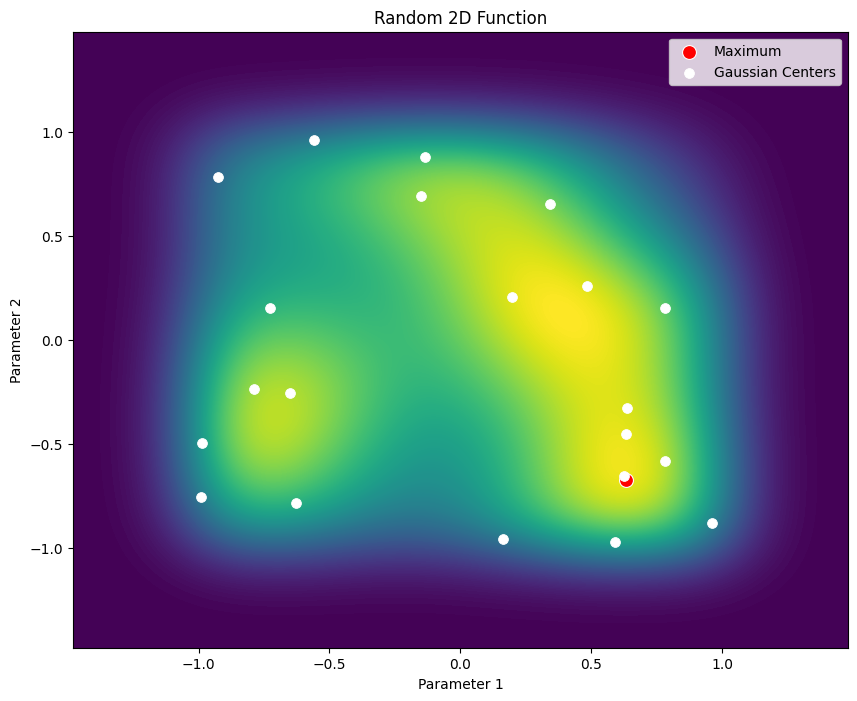

In [46]:
# Plot the function in 2D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
x1 = np.linspace(-1, 1, 50)
x2 = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x1, x2, indexing="ij")
Y = f([X1, X2])

# remove NaN values
Y[np.isnan(Y)] = 0

# Plot as a heatmap with contours
sns.kdeplot(x=X1.ravel(), y=X2.ravel(), weights=Y.ravel(), fill=True, thresh=0, levels=500, cmap="viridis")

# Get the max point, this is the ground truth
max_point = np.unravel_index(Y.argmax(), Y.shape)
max_x = [x1[max_point[0]], x2[max_point[1]]]
max_y = f(max_x)

# Plot the maximum point
sns.scatterplot(x=np.array([max_x[0]]), y=np.array([max_x[1]]), color="r", s=100, label="Maximum")

# Plot the Gaussian centers
sns.scatterplot(x=means[:, 0], y=means[:, 1], color="white", s=50, label="Gaussian Centers")

ax.set_xlabel("Parameter 1")
ax.set_ylabel("Parameter 2")
ax.set_title("Random 2D Function")
ax.legend()

print(f"Ground truth maximum: {max_x} -> {max_y}")
ground_truth = max_x

In [47]:
# Parameters for Bayesian optimization
samples_per_iteration = 5  # Number of samples to draw per iteration (can be modified)
num_iterations = 3  # Total number of iterations (including initialization)
noise_level = 0.01  # Noise level for observations

# Parameters for initialization
random_init = True  # Set to True for random initialization, False for equidistant

# Initial points for Bayesian optimization
if random_init:
    # Random initialization across the parameter space
    X_train_raw = np.random.uniform(-1.0, 1.0, (samples_per_iteration, 2))
else:
    # Sample equidistant points across surface (original initialization)
    X_train_raw = np.array([[0, 0], [-0.5, -0.5], [-0.5, 0.5], [0.5, 0.5], [0.5, -0.5]])

# Scale the input features from [-1, 1] to [0, 1] for BoTorch compatibility
X_train = Tensor((X_train_raw + 1.0) / 2.0).type(double)

# Evaluate the function at the initial points with some noise
# Note: We need to convert back to [-1, 1] range when evaluating the function
Y_train = (
    Tensor(np.array([f(x_raw) for x_raw in X_train_raw]) + np.random.normal(0, noise_level, samples_per_iteration))
    .type(double)
    .reshape(-1, 1)
)

# Store all points and values for plotting
all_X_raw = X_train_raw.copy()  # Store the raw points for plotting
all_X = X_train.clone()  # Store the scaled points for BoTorch
all_Y = Y_train.clone()

In [ ]:
# Run Bayesian optimization loop
for i in range(num_iterations):
    print(f"\nIteration {i+1}/{num_iterations}")
    
    # Fit a Gaussian Process model to the data
    model = SingleTaskGP(X_train, Y_train)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    mll = fit_gpytorch_mll(mll)
    
    # Create the acquisition function (qLogNoisyExpectedImprovement)
    sampler = SobolQMCNormalSampler(Size([1024]))
    qLogNEI = qLogNoisyExpectedImprovement(model, X_train, sampler)
    
    # Optimize the acquisition function to get new points to sample
    # Use [0, 1] bounds for BoTorch compatibility
    bounds = Tensor([[0.0, 0.0], [1.0, 1.0]])
    new_X, acq_value = optimize_acqf(
        qLogNEI, bounds=bounds, q=samples_per_iteration, num_restarts=10, raw_samples=100
    )
    
    # Convert the new points back to [-1, 1] range for function evaluation
    new_X_raw = new_X.numpy() * 2.0 - 1.0
    
    # Evaluate the function at the new points
    new_Y = Tensor(np.array([f(x) for x in new_X_raw])).type(double).reshape(-1, 1)
    
    # Print the best point found in this iteration
    best_idx = new_Y.argmax().item()
    best_x = new_X_raw[best_idx]  # type: ignore
    best_y = new_Y[best_idx].item()  # type: ignore
    print(f"Best point in this iteration: {best_x} -> {best_y}")
    
    # Store all points for plotting
    all_X_raw = np.vstack([all_X_raw, new_X_raw])
    all_X = torch.cat([all_X, new_X])
    all_Y = torch.cat([all_Y, new_Y])
    
    # Update training data for next iteration (if not the last iteration)
    if i != num_iterations - 1:
        X_train = torch.cat([X_train, new_X])
        Y_train = torch.cat([Y_train, new_Y])
    
# Find the overall best point
best_overall_idx = all_Y.argmax().item()
best_overall_x = all_X_raw[best_overall_idx]  # type: ignore
best_overall_y = all_Y[best_overall_idx].item()  # type: ignore
print(f"\nBest overall point found: {best_overall_x} -> {best_overall_y}")
print(f"Ground truth maximum: {max_x} -> {max_y}")
print(f"Distance to ground truth: {np.linalg.norm(best_overall_x - np.array(max_x))}")


Iteration 1/3
Best point in this iteration: [ 0.45444548 -0.3654915 ] -> 11.491188049316406

Iteration 2/3
Best point in this iteration: [ 0.52994263 -0.6088118 ] -> 12.639630317687988

Iteration 3/3
Best point in this iteration: [ 0.63517237 -0.6600373 ] -> 13.293437957763672

Best overall point found: [ 0.63517237 -0.66003728] -> 13.293437957763672
Ground truth maximum: [0.6326530612244896, -0.6734693877551021] -> 13.29082870551138
Distance to ground truth: 0.013666325190650457


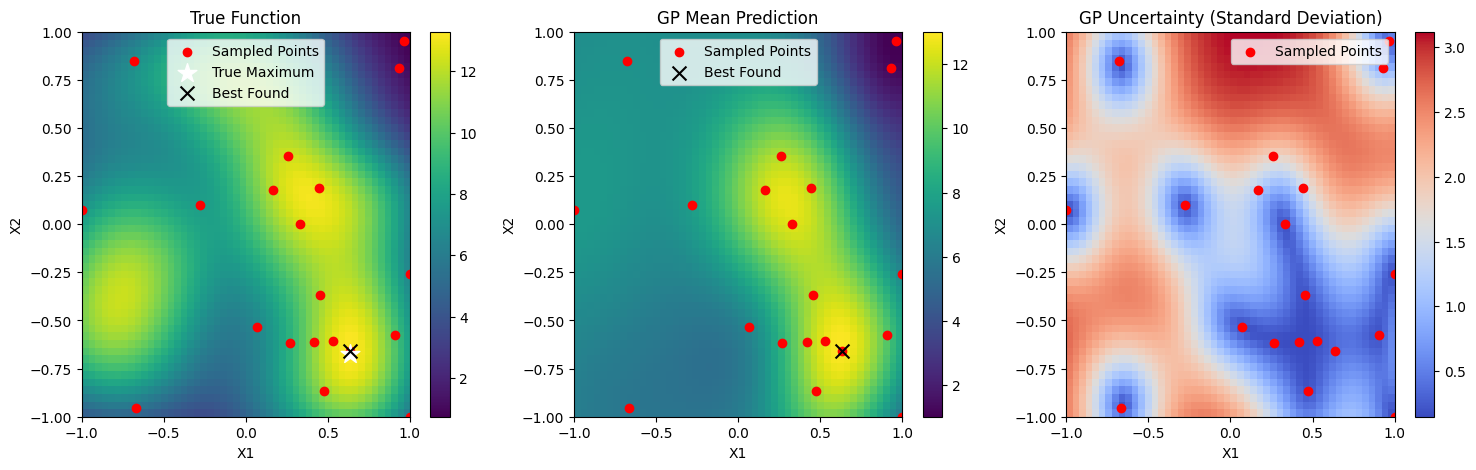

In [49]:
# Generate a grid of test points for visualization
grid_size = 50
x1 = torch.linspace(-1, 1, grid_size)
x2 = torch.linspace(-1, 1, grid_size)
X1, X2 = torch.meshgrid(x1, x2, indexing="ij")
test_X_raw = torch.cat([X1.reshape(-1, 1), X2.reshape(-1, 1)], dim=1)

# Scale the test points from [-1, 1] to [0, 1] for model prediction
test_X = (test_X_raw + 1.0) / 2.0

# Predict using the trained model
model.eval()
with torch.no_grad():
    pred = model.posterior(test_X)
    mean = pred.mean.view(grid_size, grid_size).numpy()
    stddev = pred.variance.sqrt().view(grid_size, grid_size).numpy()

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# True function
true_Y = f([X1.numpy(), X2.numpy()])
c0 = ax[0].imshow(true_Y.T, extent=[-1, 1, -1, 1], origin="lower", cmap="viridis", aspect="auto")
ax[0].scatter(all_X_raw[:, 0], all_X_raw[:, 1], color="r", marker="o", label="Sampled Points")
ax[0].scatter(max_x[0], max_x[1], color="white", marker="*", s=200, label="True Maximum")
ax[0].scatter(best_overall_x[0], best_overall_x[1], color="black", marker="x", s=100, label="Best Found")
ax[0].set_title("True Function")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")
ax[0].legend()
fig.colorbar(c0, ax=ax[0])

# Mean Prediction Heatmap
c1 = ax[1].imshow(mean.T, extent=[-1, 1, -1, 1], origin="lower", cmap="viridis", aspect="auto")
ax[1].scatter(all_X_raw[:, 0], all_X_raw[:, 1], color="r", marker="o", label="Sampled Points")
ax[1].scatter(best_overall_x[0], best_overall_x[1], color="black", marker="x", s=100, label="Best Found")
ax[1].set_title("GP Mean Prediction")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")
ax[1].legend()
fig.colorbar(c1, ax=ax[1])

# Uncertainty (Standard Deviation) Heatmap
c2 = ax[2].imshow(stddev.T, extent=[-1, 1, -1, 1], origin="lower", cmap="coolwarm", aspect="auto")
ax[2].scatter(all_X_raw[:, 0], all_X_raw[:, 1], color="r", marker="o", label="Sampled Points")
ax[2].set_title("GP Uncertainty (Standard Deviation)")
ax[2].set_xlabel("X1")
ax[2].set_ylabel("X2")
ax[2].legend()
fig.colorbar(c2, ax=ax[2])